In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul 23 03:16:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import missingno as msno
import re

# import xlrd
import warnings
warnings.filterwarnings('ignore')
# plt.style.use('seaborn') #그래프 스타일

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Reshape,Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, ActivityRegularization, Average, Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50, ResNet101V2,EfficientNetB0, InceptionV3

# Data preparation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=False,
    validation_split=0.2  # Split the data into training (80%) and validation (20%)
)

train_dir = '/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train'

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Use 'training' subset for training
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use 'validation' subset for validation
)


Found 736 images belonging to 2 classes.
Found 183 images belonging to 2 classes.


In [38]:
# MobileNetV2
base_model1 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dropout(0.2)(x1)
predictions1 = Dense(1, activation='sigmoid')(x1)
model1 = Model(inputs=base_model1.input, outputs=predictions1)

# ResNet101V2
base_model2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dropout(0.2)(x2)
predictions2 = Dense(1, activation='sigmoid')(x2)
model2 = Model(inputs=base_model2.input, outputs=predictions2)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint1 = ModelCheckpoint(filepath='./model/mobilenet_model.h5', monitor='val_loss', verbose=1, save_best_only=True,  mode='auto')
model_checkpoint2 = ModelCheckpoint(filepath='./model/resnet_model.h5', monitor='val_loss', verbose=1, save_best_only=True,  mode='auto')



# Compile and train the models
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model1.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stop, model_checkpoint1])
model2.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stop, model_checkpoint2])

#AutoEncoder

# Prepare a dataset for anomaly detection
# anomaly_datagen = ImageDataGenerator(rescale=1./255)

# anomaly_generator = anomaly_datagen.flow_from_directory(
#     train_dir,
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='binary',
#     subset='training'  # Use training data only
# )

# Anomaly data generator
anomaly_datagen = ImageDataGenerator(rescale=1./255)
anomaly_generator = anomaly_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/',
    target_size=(224, 224),
    batch_size=32,
    classes=['good'],
    class_mode='input',  # Set class_mode to 'input' to yield the same image as both x and y
)

# Define an Autoencoder model
input_img = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the Autoencoder model
autoencoder.fit(anomaly_generator, epochs=50)

# Ensemble
def ensemble(models):
    outputs = [model.output for model in models]
    y = Average()(outputs)
    model = Model([model.input for model in models], y, name='ensemble')
    return model

ensemble_model = ensemble([model1, model2])
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9239
Epoch 1: val_loss improved from inf to 0.96524, saving model to ./model/mobilenet_model.h5
23/23 [==============================] - 41s 626ms/step - loss: 0.1938 - accuracy: 0.9239 - val_loss: 0.9652 - val_accuracy: 0.5956
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9796
Epoch 2: val_loss improved from 0.96524 to 0.82353, saving model to ./model/mobilenet_model.h5
23/23 [==============================] - 13s 588ms/step - loss: 0.0659 - accuracy: 0.9796 - val_loss: 0.8235 - val_accuracy: 0.8852
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9851
Epoch 3: val_loss did not improve from 0.82353
23/23 [==============================] - 13s 563ms/step - loss: 0.0444 - accuracy: 0.9851 - val_loss: 1.3575 - val_accuracy: 0.8907
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.

In [39]:
# 이상 탐지 모델을 정의하고 학습합니다.
# Autoencoder 모델을 예시로 사용하였습니다.
# input_img = Input(shape=(224, 224, 3))
# x = Flatten()(input_img)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# encoded = Dense(32, activation='relu')(x)

# x = Dense(64, activation='relu')(encoded)
# x = Dense(128, activation='relu')(x)
# decoded = Dense(224 * 224 * 3, activation='sigmoid')(x)

input_img = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = Reshape((224, 224, 3))(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 'good' 이미지만을 사용하여 Autoencoder를 학습합니다.
# good_images = os.path.join(train_dir, 'good')
# good_images = os.path.join(train_dir, 'good')


good_datagen = ImageDataGenerator(rescale=1./255)
good_generator = good_datagen.flow_from_directory(
                                                # os.path.dirname(good_images),
                                                train_dir,
                                                target_size=(224, 224),
                                                batch_size=16,
                                                class_mode='input',
                                                classes=['good'])

# Train the Autoencoder model
autoencoder.fit(good_generator, epochs=50)

Found 99 images belonging to 1 classes.
Epoch 1/50
7/7 [==============================] - 2s 69ms/step - loss: 0.1506
Epoch 2/50
7/7 [==============================] - 1s 78ms/step - loss: 0.0563
Epoch 3/50
7/7 [==============================] - 1s 77ms/step - loss: 0.0474
Epoch 4/50
7/7 [==============================] - 1s 83ms/step - loss: 0.0396
Epoch 5/50
7/7 [==============================] - 1s 80ms/step - loss: 0.0294
Epoch 6/50
7/7 [==============================] - 1s 79ms/step - loss: 0.0174
Epoch 7/50
7/7 [==============================] - 1s 93ms/step - loss: 0.0059
Epoch 8/50
7/7 [==============================] - 1s 79ms/step - loss: 0.0033
Epoch 9/50
7/7 [==============================] - 1s 78ms/step - loss: 0.0032
Epoch 10/50
7/7 [==============================] - 1s 82ms/step - loss: 0.0025
Epoch 11/50
7/7 [==============================] - 1s 83ms/step - loss: 0.0021
Epoch 12/50
7/7 [==============================] - 1s 93ms/step - loss: 0.0019
Epoch 13/50
7/7 [====

In [40]:
# Ensemble
def ensemble(models):
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    model = Model([model.input for model in models], y, name='ensemble')
    return model

ensemble_model = ensemble([model1, model2])
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Get validation images and labels as numpy arrays
validation_images, validation_labels = next(validation_generator)

# Predict using the ensemble model
# Predict using the ensemble model
ensemble_predictions = ensemble_model.predict([validation_images]*2)


# Detect anomalies using the Autoencoder
decoded_images = autoencoder.predict(validation_images)
mse = np.mean(np.power(validation_images - decoded_images, 2), axis=(1,2,3))
anomaly_indices = mse > np.percentile(mse, 95)  # Adjust the percentile as needed


1/1 [==============================] - 0s 103ms/step


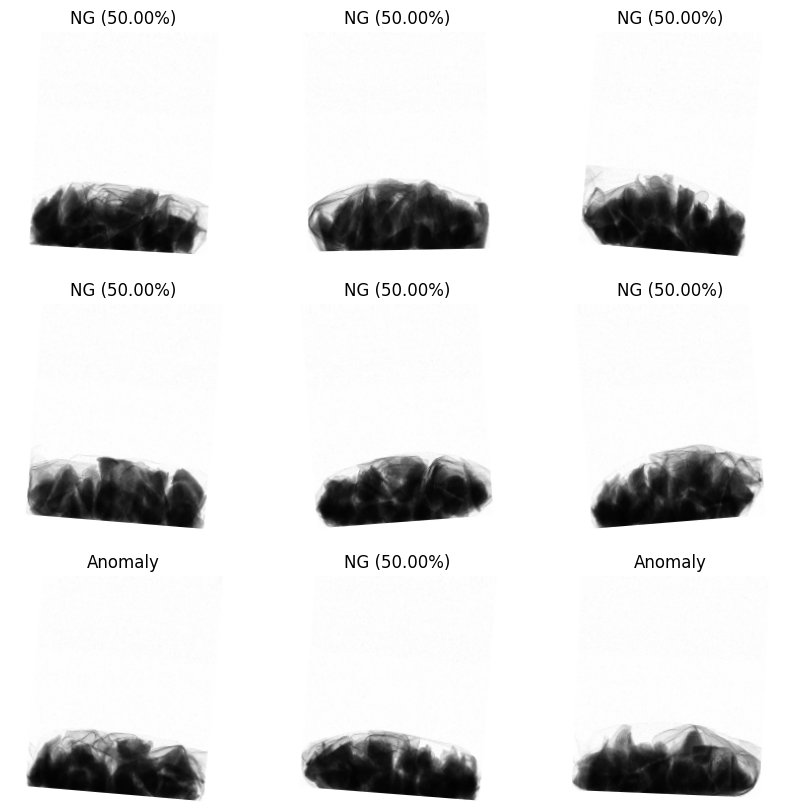

In [41]:
import matplotlib.pyplot as plt

# Select a random subset of validation images
num_images = 9
random_indices = np.random.choice(np.arange(len(validation_images)), size=num_images, replace=False)
random_images = validation_images[random_indices]
random_labels = validation_labels[random_indices]
random_predictions = ensemble_predictions[random_indices]
random_anomalies = anomaly_indices[random_indices]

# Now use this threshold in the testing code
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.ravel()
for i, image in enumerate(random_images):
    axes[i].imshow(image)
    axes[i].axis('off')
    pred = random_predictions[i][0]
    if random_anomalies[i]:
        axes[i].set_title('Anomaly')
    elif pred < 0.6:
        axes[i].set_title('NG ({:.2f}%)'.format((1-pred) * 100))
    else:
        axes[i].set_title('GOOD ({:.2f}%)'.format(pred * 100))
plt.show()


In [42]:





#Threshold 값 을 평균으로
# Predict on all validation images
val_pred = ensemble_model.predict(validation_generator)

# Compute average prediction for each class
average_good_pred = np.mean(val_pred[val_labels == 0])
average_ng_pred = np.mean(val_pred[val_labels == 1])

# Use the average of the two averages as the classification threshold
threshold = (average_good_pred + average_ng_pred) / 2

# Now use this threshold in the testing code
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.ravel()
for i, image in enumerate(random_images):
    axes[i].imshow(image)
    axes[i].axis('off')
    pred = ensemble_predictions[i][0]
    if anomaly_indices[i]:
        axes[i].set_title('Anomaly')
    elif pred < threshold:
        axes[i].set_title('NG ({:.2f}%)'.format((1-pred) * 100))
    else:
        axes[i].set_title('GOOD ({:.2f}%)'.format(pred * 100))
plt.show()


ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt

# Choose random images from the validation set
random_indices = np.random.randint(0, len(validation_generator), size=9)
random_images = np.array([validation_generator[i][0] for i in random_indices])
random_labels = np.array([validation_generator[i][1] for i in random_indices])

# Predict the class and detect anomalies for each image
ensemble_predictions = ensemble_model.predict(random_images)
autoencoder_reconstructions = autoencoder.predict(random_images)
reconstruction_errors = np.abs(random_images - autoencoder_reconstructions)
anomaly_indices = reconstruction_errors > threshold

# Display the images with their predicted class and whether they are anomalies
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.ravel()
for i, image in enumerate(random_images):
    axes[i].imshow(image)
    axes[i].axis('off')
    pred = ensemble_predictions[i][0]
    if anomaly_indices[i]:
        axes[i].set_title('Anomaly')
    elif pred < 0.5:
        axes[i].set_title('NG ({:.2f}%)'.format((1-pred) * 100))
    else:
        axes[i].set_title('GOOD ({:.2f}%)'.format(pred * 100))
plt.show()
